# 07 - Data wrangling

This notebook contains solution proposals to the home exercises.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import os

### 📚 Exercise 1: Titanic aggregations

Load and merge the data in <code>titanic.csv</code> and <code>titanic_additional.csv</code> to perform the following aggregations:

In [2]:
# Import data
titanic = pd.read_csv('data/titanic.csv')
titanic_add = pd.read_csv('data/titanic_additional.csv')

# Merge data 
titanic = titanic.merge(titanic_add, on = ['PassengerId', 'Name', 'Sex'], how = 'inner')

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Ticket,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,A/5 21171,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,PC 17599,C85,C
2,3,1,3,"Heikkinen, Miss Laina",female,26.0,7.9250,STON/O2. 3101282,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,113803,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,373450,NaN,S


1. Compute the average survival rate by sex.

In [3]:
titanic.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

2. Count the number of passengers aged +50. Compute the average survival rate by sex for this group.

In [4]:
len(titanic[titanic['Age'] > 50])

64

In [5]:
titanic[titanic['Age'] > 50].groupby('Sex')['Survived'].mean()

Sex
female    0.941176
male      0.127660
Name: Survived, dtype: float64

3. Count the number of passengers below the age of 20 by class and sex. Compute the average survival rate for this group by class and sex.

In [6]:
len(titanic[titanic['Age'] < 20])

164

In [7]:
titanic[titanic['Age'] < 20].groupby(['Sex', 'Pclass']).size()

Sex     Pclass
female  1         14
        2         16
        3         45
male    1          7
        2         19
        3         63
dtype: int64

4. Count the number of non-missing values in each column by class and sex. 

In [8]:
titanic.groupby(['Pclass', 'Sex']).count()  # Excl. missing observations
# titanic.groupby(['Pclass', 'Sex']).size() # Incl. missing observations

PassengerId  Survived  Name  Age  Fare  Ticket  Cabin  Embarked
Pclass Sex                                                                    
1      female           94        94    94   85    94      94     81        92
       male            122       122   122  101   122     122     95       122
2      female           76        76    76   74    76      76     10        76
       male            108       108   108   99   108     108      6       108
3      female          144       144   144  102   144     144      6       144
       male            347       347   347  253   347     347      6       347

5. Compute the minimum, maximum and average age by embarkation port (column `Embarked`) in a single `agg` operation. 

In [9]:
# Alternative 1
titanic.groupby('Embarked')['Age'].agg(['min', 'max', 'mean'])

,min,max,mean
Embarked,,,
C,0.42,71.0,30.814769
Q,2.00,70.5,28.089286
S,0.67,80.0,29.445397


In [10]:
# Alternative 2
titanic.groupby('Embarked').agg(
    min_age = ('Age', 'min'),
    max_age = ('Age', 'max'),
    mean_age = ('Age', 'mean')
)

,min_age,max_age,mean_age
Embarked,,,
C,0.42,71.0,30.814769
Q,2.00,70.5,28.089286
S,0.67,80.0,29.445397


6. Compute the number of passengers, the average age and the fraction of women by embarkation port in a single `agg` operation.

   *Hint*: to compute the fraction of women, you can first create a numerical indicator variable for females.


In [11]:
titanic['Sex_ind'] = 0
titanic.loc[titanic['Sex'] == 'female', 'Sex_ind'] = 1

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Ticket,Cabin,Embarked,Sex_ind
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,A/5 21171,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,PC 17599,C85,C,1
2,3,1,3,"Heikkinen, Miss Laina",female,26.0,7.9250,STON/O2. 3101282,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,113803,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,373450,NaN,S,0


In [12]:
titanic.groupby('Embarked').agg(
    num_passengers = ('PassengerId', 'count'),
    mean_age = ('Age', 'mean'),
    share_women = ('Sex_ind', 'mean')
)

,num_passengers,mean_age,share_women
Embarked,,,
C,168,30.814769,0.434524
Q,77,28.089286,0.467532
S,644,29.445397,0.315217


### 📚 Exercise 2: Working with string data

In this exercise, you will work with the original Titanic data set in `titanic.csv` and additional data stored in `titanic_address.csv`, which contains the address for each passenger. Note that the second data set contains address information only for passengers from the UK, while all other passengers (non-UK) have missing address information.

The goal of the exercise is to calculate the survival rate by country of residence (for this exercise, we restrict ourselves to the UK, so these will be England, Scotland, Wales etc.).

**Task 1**: Load `titanic.csv` and `titanic_address.csv` into two DataFrames.

Inspect the columns contained in both data sets. As you can see, the orignal data contains the full name including the title and potential maiden name (for married women) in a single column. The address data contains this information in seperate columns. You want to merge these data sets, but first you need to create common keys (i.e., columns) in both DataFrames.

In [13]:
titanic = pd.read_csv('data/titanic.csv')

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833
2,3,1,3,"Heikkinen, Miss Laina",female,26.0,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500


In [14]:
titanic_address = pd.read_csv('data/titanic_address.csv')

titanic_address.head()

,Title,LastName,FirstName,MaidenName,City,Postcode,Address
0,Mr.,Christmann,Emil,NaN,Chester,CH6 34H,3 Graham ways
1,Miss,Heikkinen,Laina,NaN,Bolton,BL0 1XG,0 Griffin wells
2,Lady.,Duff Gordon,Lucille Christiana,Sutherland,NaN,NaN,NaN
3,Miss,Pettersson,Ellen Natalia,NaN,Northampton,NN0 H5R,889 Murray glen
4,Mr.,Odahl,Nils Martin,NaN,Derby,DE7 QZ7,"Studio 2, Long courts"


**Task 2**: In the DataFrame with the original Titanic data, split the name information into three columns just like the columns in the second DataFrame by doing the following:
- Restrict the sample to men only. (This simplifies the task. Women in this data set have much more complicated names as they contain both their husband's and their maiden name). The filtered DataFrame should have 577 passengers.
- Split the `Name` column by `,` to extract the last name and the remainder as seperate columns. You can achieve this by using the [`partition`]((https://pandas.pydata.org/docs/reference/api/pandas.Series.str.partition.html#pandas.Series.str.partition) string method) string method.
- Split the remainder (containing the title and first name) using the space character `" "` as seperator to obtain individual columns for the title and the first name.
- Store the three data series in the original DataFrame (using the column names `FirstName`,     `LastName` and `Title`) and delete the `Name` column which is no longer needed.

*Hint*: Make sure that you don't have any leading or trailing whitespace at the start/end of the strings after partition. You can remove whitespace using the [`strip`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html) method
```
df['FirstName'].str.strip()
```

In [15]:
# Keep only men
titanic = titanic[titanic['Sex'] == 'male'].reset_index(drop = True).copy()

print(len(titanic))
titanic.head()

577


,PassengerId,Survived,Pclass,Name,Sex,Age,Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500
1,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500
2,6,0,3,"Moran, Mr. James",male,NaN,8.4583
3,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,51.8625
4,8,0,3,"Palsson, Master Gosta Leonard",male,2.0,21.0750


In [16]:
# Extract last names and rest of names as pandas Series
# (Note: use strip method to remove trailing whitespace at start and end of string)
lastnames = titanic['Name'].str.partition(',')[0].str.strip()
remainder = titanic['Name'].str.partition(',')[2].str.strip()

In [17]:
# Extract titles and first names as pandas Series
titles = remainder.str.partition(' ')[0].str.strip()
firstnames = remainder.str.partition(' ')[2].str.strip()

In [18]:
# Drop name column from df
titanic.drop('Name', axis = 1, inplace = True)

# Add new name columns to df
titanic['Title'] = titles
titanic['FirstName'] = firstnames
titanic['LastName'] = lastnames

titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Title,FirstName,LastName
0,1,0,3,male,22.0,7.2500,Mr.,Owen Harris,Braund
1,5,0,3,male,35.0,8.0500,Mr.,William Henry,Allen
2,6,0,3,male,NaN,8.4583,Mr.,James,Moran
3,7,0,1,male,54.0,51.8625,Mr.,Timothy J,McCarthy
4,8,0,3,male,2.0,21.0750,Master,Gosta Leonard,Palsson


**Task 3**: Merge the original Titanic data with the address data based on the name columns you just created using a *left join*. Since we don't have address information for non-UK residence, you can drop the passengers with missing addresses. The merged DataFrame should have 471 passengers with non-missing address information.

In [19]:
# Merge the two dfs
titanic = titanic.merge(titanic_address, on = ['Title', 'FirstName', 'LastName'], how = 'left')

# Drop rows with missing city info using dropna method
titanic.dropna(subset = 'City', axis = 0, inplace = True)
titanic.reset_index(drop = True, inplace = True)

# ...or alternatively, drop missings by filtering
# titanic = titanic[titanic['City'].notna()].reset_index(drop = True).copy()

print(len(titanic))
titanic.head()

471


,PassengerId,Survived,Pclass,Sex,Age,Fare,Title,FirstName,LastName,MaidenName,City,Postcode,Address
0,1,0,3,male,22.0,7.2500,Mr.,Owen Harris,Braund,NaN,Portsmouth,PO9 1CI,"Flat 6, Dean well"
1,5,0,3,male,35.0,8.0500,Mr.,William Henry,Allen,NaN,Chelmsford,CM3 V66,"Studio 65, Leah falls"
2,6,0,3,male,NaN,8.4583,Mr.,James,Moran,NaN,Southall,UB8 8SZ,9 Teresa lakes
3,7,0,1,male,54.0,51.8625,Mr.,Timothy J,McCarthy,NaN,Wakefield,WF0 GXT,"Studio 7, Mark dale"
4,8,0,3,male,2.0,21.0750,Master,Gosta Leonard,Palsson,NaN,London,W55 LK3,"Studio 11B, Paula lane"


**Task 4**: The file `UK_post_codes.csv` contains UK post code prefixes (which you can ignore), the corresponding city, and the corresponding country.

Import the file and merge this data with your passenger data set using a *left join*.

*Hint*: The data with the post codes contains duplicate rows for countries due to many postal codes. Before merging, you should ensure that you have only one row for each country-city combination. You can drop duplicate rows using the [`drop_duplicates`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html) method.

In [20]:
# Import file
df_post = pd.read_csv('data/UK_post_codes.csv')

df_post.head()

,Prefix,City,Country
0,AB,Aberdeen,Scotland
1,AL,St Albans,England
2,B,Birmingham,England
3,BA,Bath,England
4,BB,Blackburn,England


In [21]:
# Drop duplicated rows of country-city combinations
df_post.drop_duplicates(subset = ['City', 'Country'], keep = 'first', inplace = True)

# Drop postal code prefix
df_post.drop('Prefix', axis = 1, inplace = True)

print(len(df_post))
print(df_post['City'].nunique())
df_post.head()

113
113


,City,Country
0,Aberdeen,Scotland
1,St Albans,England
2,Birmingham,England
3,Bath,England
4,Blackburn,England


In [22]:
# Merge titanic data and UK locations
titanic = titanic.merge(df_post, on = 'City', how = 'left')

print(len(titanic))
titanic.head()

471


,PassengerId,Survived,Pclass,Sex,Age,Fare,Title,FirstName,LastName,MaidenName,City,Postcode,Address,Country
0,1,0,3,male,22.0,7.2500,Mr.,Owen Harris,Braund,NaN,Portsmouth,PO9 1CI,"Flat 6, Dean well",England
1,5,0,3,male,35.0,8.0500,Mr.,William Henry,Allen,NaN,Chelmsford,CM3 V66,"Studio 65, Leah falls",England
2,6,0,3,male,NaN,8.4583,Mr.,James,Moran,NaN,Southall,UB8 8SZ,9 Teresa lakes,England
3,7,0,1,male,54.0,51.8625,Mr.,Timothy J,McCarthy,NaN,Wakefield,WF0 GXT,"Studio 7, Mark dale",England
4,8,0,3,male,2.0,21.0750,Master,Gosta Leonard,Palsson,NaN,London,W55 LK3,"Studio 11B, Paula lane",England


**Task 5**: Using the finale DataFrame, compute the average survivial rate by country of residence.

In [23]:
titanic.groupby('Country')['Survived'].mean()

Country
England             0.158177
Northern Ireland    0.000000
Scotland            0.179104
Wales               0.120000
Name: Survived, dtype: float64

### 📚 Exercise 3: Importing multiple files

The subfolder `stocks` in the `data` folder contains data on prices and traded volume for each weekday in 2020 for 10 different companies. The data for each company is stored in a seperate csv file with the company ticker as the file name.

Your task is to import and combine the data sets into a single DataFrame and then calculate the monthly sum of traded volume by company.

**Task 1**: Import the files and concat them into a single DataFrame. Make sure that the dates in the final DataFrame is a datetime object.

*Hint*: Create a list of all the file names in the folder (e.g., use [`listdir`](https://docs.python.org/3/library/os.html#os.listdir) from `os` to generate the list) and then import each file in a for loop in which you append each DataFrame to a list. Use `concat` to combine all the DataFrames in the final list.

In [24]:
# Empty list to store dfs in
df_lst = []

# Generate list of all files in "stocks" folder
files = os.listdir('data/stocks')

for file in files:
    
    # Import file
    df_temp = pd.read_csv('data/stocks/' + file)

    # Convert date to datetime
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])

    # Add column with ticker name
    df_temp['Ticker'] = file.split('.')[0] # split string on '.'
    #df_temp['Ticker'] = files[0][:-4] # or index the string without last 4 characters

    # Append temp df to list
    df_lst.append(df_temp)

print(len(df_lst))

10


In [25]:
# Concat list of dfs into single df
df_stocks = pd.concat(df_lst).reset_index(drop = True)

print(len(df_stocks))
print(df_stocks['Ticker'].unique())
df_stocks.head()

2520
['AMZN' 'MSFT' 'FB' 'JPM' 'TSLA' 'GOOG' 'BABA' 'AAPL' 'WMT' 'JNJ']


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2020-01-02,1875.000000,1898.010010,1864.150024,1898.010010,1898.010010,4029000,AMZN
1,2020-01-03,1864.500000,1886.199951,1864.500000,1874.969971,1874.969971,3764400,AMZN
2,2020-01-06,1860.000000,1903.689941,1860.000000,1902.880005,1902.880005,4061800,AMZN
3,2020-01-07,1904.500000,1913.890015,1892.040039,1906.859985,1906.859985,4044900,AMZN
4,2020-01-08,1898.040039,1911.000000,1886.439941,1891.969971,1891.969971,3508000,AMZN


**Task 2**: Calculate the monthly sum of traded volume for each ticker in the data in three different ways:
1. Compute the monthly sums "manually" by looping over the data instead of using pandas aggregation methods (e.g., `groupby`).

   *Hint*: use a nested `for` loop, in which the outer loop iterates over ticker names, and the inner loop iterates over months. Recall that you can use the `dt` accessor to access time properties from a datetime object.

In [26]:
tickers = []
months = []
sums = []

# Outer loop to filter on ticker
for ticker in df_stocks['Ticker'].unique():
    df1 = df_stocks[df_stocks['Ticker'] == ticker]

    # Inner loop to filter on month
    for month in range(1, 13):
        df2 = df1[df1['Date'].dt.month == month]

        # Append each ticker, month and sum to lists
        tickers.append(ticker)
        months.append(month)
        sums.append(df2['Volume'].sum())
        

In [27]:
# Create df from dict of lists from for loop
pd.DataFrame({
    'Ticker' : tickers,
    'Month' : months,
    'Volume' : sums
})

,Ticker,Month,Volume
0,AMZN,1,84698300
1,AMZN,2,92530300
2,AMZN,3,163809100
3,AMZN,4,124631900
4,AMZN,5,82617800
...,...,...,...
115,JNJ,8,109982700
116,JNJ,9,138801300
117,JNJ,10,137285300
118,JNJ,11,153635100


2. Compute the monthly sums using the pandas aggregation method `groupby` instead of loops.

In [28]:
df_stocks.groupby([df_stocks['Date'].dt.month, 'Ticker'])['Volume'].sum().reset_index()

,Date,Ticker,Volume
0,1,AAPL,2934370400
1,1,AMZN,84698300
2,1,BABA,304096100
3,1,FB,347314600
4,1,GOOG,33691600
...,...,...,...
115,12,JNJ,153830300
116,12,JPM,265573600
117,12,MSFT,573863900
118,12,TSLA,1146696100


3. Compute the monthly sums also using the pandas method `resample`.

**Note**: This works because our data contains only daily observations within a single year. 

In [29]:
df_stocks.set_index('Date').groupby('Ticker').resample('ME')['Volume'].sum().reset_index()

,Ticker,Date,Volume
0,AAPL,2020-01-31,2934370400
1,AAPL,2020-02-29,3019851200
2,AAPL,2020-03-31,6280072400
3,AAPL,2020-04-30,3266123200
4,AAPL,2020-05-31,2806405200
...,...,...,...
115,WMT,2020-08-31,230024800
116,WMT,2020-09-30,268766000
117,WMT,2020-10-31,128998800
118,WMT,2020-11-30,137933500


### 📚 Exercise 4: Reshaping electricity data

The file `eurostat.xlsx` contains data on electricity consumption (in gigawatt-hours) for European countries from 2001 to 2023. 

1. Import the file and and keep only observations for the years 2001 to 2020 and for actual countries (i.e., drop the EU/Euro aggregates). The data should have 41 countries observed for 20 unique years.
   
   *Hint*: See the solution proposal to home exercise #2 in lecture 5.

In [30]:
# Import file
df_euro = pd.read_excel(
    'data/eurostat.xlsx', 
    sheet_name = 'Sheet 1',           # Specify which sheet to import
    skiprows = list(range(9)) + [10], # Skip rows at the top of the file
    skipfooter = 5,                   # Skip rows at the bottom of the file
    na_values = ':'                   # Specify that ":" indicates NaN
)

# Rename column to country
df_euro.rename(columns = {'TIME' : 'Country'}, inplace = True)

# Keep only columns with country and year observations
# (keep only years 2000 to 2020)
years = [str(i) for i in range(2001, 2021)]
df_euro = df_euro[['Country'] + years].copy()

# Drop aggregates
df_euro = df_euro[~df_euro['Country'].isin(['European Union - 27 countries (from 2020)', 'Euro area – 20 countries (from 2023)'])].copy()

df_euro.head()

,Country,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2,Belgium,79816.0,80438.0,82065.0,83034.5,82983.1,85663.1,85675.50,85885.900,80007.300,...,84064.300,84032.900,84231.900,82040.800,83023.800,83183.700,83766.200,84222.800,83291.300,80897.500
3,Bulgaria,25776.0,25287.0,26425.0,26241.0,27213.0,28444.0,29286.00,29923.000,28259.000,...,29589.000,29113.000,28660.000,28945.000,29638.000,30259.000,31445.670,31389.999,31094.533,30498.913
4,Czechia,53775.0,53669.0,54807.0,56388.0,57664.0,59422.0,59740.01,60463.654,57098.304,...,57501.558,58005.289,57561.467,57592.718,58661.342,59762.129,60931.039,61327.781,61193.576,59111.206
5,Denmark,33213.0,33173.0,33159.0,33719.0,34254.0,34681.0,34458.00,34132.000,32425.539,...,32608.237,32082.935,32160.638,31583.293,31769.169,32061.184,32255.674,31896.936,32192.383,31479.924
6,Germany,512637.0,525510.0,531751.0,538406.0,539471.0,544629.0,545614.00,542991.000,513898.000,...,539891.000,538206.000,536440.000,524827.000,528350.000,530551.000,531318.000,521809.000,507543.000,492821.000


In [31]:
# Check data types
df_euro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, 2 to 42
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  41 non-null     object 
 1   2001     36 non-null     float64
 2   2002     36 non-null     float64
 3   2003     36 non-null     float64
 4   2004     36 non-null     float64
 5   2005     37 non-null     float64
 6   2006     37 non-null     float64
 7   2007     37 non-null     float64
 8   2008     37 non-null     float64
 9   2009     37 non-null     float64
 10  2010     38 non-null     float64
 11  2011     38 non-null     float64
 12  2012     38 non-null     float64
 13  2013     39 non-null     float64
 14  2014     41 non-null     float64
 15  2015     41 non-null     float64
 16  2016     41 non-null     float64
 17  2017     41 non-null     float64
 18  2018     41 non-null     float64
 19  2019     41 non-null     float64
 20  2020     40 non-null     float64
dtypes: float64(20), object(

In [32]:
# Check unique countries
print(df_euro['Country'].nunique())
print(df_euro['Country'].unique())

41
['Belgium' 'Bulgaria' 'Czechia' 'Denmark' 'Germany' 'Estonia' 'Ireland'
 'Greece' 'Spain' 'France' 'Croatia' 'Italy' 'Cyprus' 'Latvia' 'Lithuania'
 'Luxembourg' 'Hungary' 'Malta' 'Netherlands' 'Austria' 'Poland'
 'Portugal' 'Romania' 'Slovenia' 'Slovakia' 'Finland' 'Sweden' 'Iceland'
 'Liechtenstein' 'Norway' 'United Kingdom' 'Bosnia and Herzegovina'
 'Montenegro' 'Moldova' 'North Macedonia' 'Georgia' 'Albania' 'Serbia'
 'Türkiye' 'Ukraine' 'Kosovo*']


In [33]:
# Check missing values
df_euro.isna().sum()

Country    0
2001       5
2002       5
2003       5
2004       5
2005       4
2006       4
2007       4
2008       4
2009       4
2010       3
2011       3
2012       3
2013       2
2014       0
2015       0
2016       0
2017       0
2018       0
2019       0
2020       1
dtype: int64

2. Many countries have missing observations on electricity consumption in some year. Calculate how many years each country has a non-missing observation.

   *Hint*: Reshape first the data from wide to long using the pandas method `pivot`, and then count the number of non-missing observations for each country in a `groupby`.

In [34]:
# Reshape data from long to wide
df_euro = df_euro.melt(
    id_vars = 'Country',
    value_name = 'Electricity',
    var_name =  'Year'
)

# Sort values according to year for each country
df_euro.sort_values(['Country', 'Year'], inplace = True)

df_euro

,Country,Year,Electricity
36,Albania,2001,4106.000
77,Albania,2002,4780.000
118,Albania,2003,4431.000
159,Albania,2004,5424.000
200,Albania,2005,5169.000
...,...,...,...
645,United Kingdom,2016,311296.896
686,United Kingdom,2017,306792.884
727,United Kingdom,2018,307374.598
768,United Kingdom,2019,302661.601


In [35]:
# Calculate how many electricity observations for each country
# (note: count method only includes non-missing values)
country_year_counts = df_euro.groupby('Country')['Electricity'].count()

country_year_counts

Country
Albania                   20
Austria                   20
Belgium                   20
Bosnia and Herzegovina     7
Bulgaria                  20
Croatia                   20
Cyprus                    20
Czechia                   20
Denmark                   20
Estonia                   20
Finland                   20
France                    20
Georgia                    8
Germany                   20
Greece                    20
Hungary                   20
Iceland                   20
Ireland                   20
Italy                     20
Kosovo*                   20
Latvia                    20
Liechtenstein              7
Lithuania                 20
Luxembourg                20
Malta                     20
Moldova                   11
Montenegro                16
Netherlands               20
North Macedonia           20
Norway                    20
Poland                    20
Portugal                  20
Romania                   20
Serbia                    20
Slovak

3. Drop the countries from the data that you do not observe for every single year between 2001 and 2020. Note that you should have 35 countries left in the data.

In [36]:
# Note: we can filter the country-year counts that we created above
max_years = df_euro['Year'].nunique()
country_year_counts[country_year_counts == max_years]

Country
Albania            20
Austria            20
Belgium            20
Bulgaria           20
Croatia            20
Cyprus             20
Czechia            20
Denmark            20
Estonia            20
Finland            20
France             20
Germany            20
Greece             20
Hungary            20
Iceland            20
Ireland            20
Italy              20
Kosovo*            20
Latvia             20
Lithuania          20
Luxembourg         20
Malta              20
Netherlands        20
North Macedonia    20
Norway             20
Poland             20
Portugal           20
Romania            20
Serbia             20
Slovakia           20
Slovenia           20
Spain              20
Sweden             20
Türkiye            20
Ukraine            20
Name: Electricity, dtype: int64

In [37]:
# Extract countries (from index) in filtered country-year counts
complete_countries = country_year_counts[country_year_counts == max_years].index

# Filter df so that we only keep countries observed all years
df_euro = df_euro[df_euro['Country'].isin(complete_countries)].copy()

print(df_euro['Country'].nunique())
df_euro.head()

35


,Country,Year,Electricity
36,Albania,2001,4106.0
77,Albania,2002,4780.0
118,Albania,2003,4431.0
159,Albania,2004,5424.0
200,Albania,2005,5169.0


4. Calculate the average annual electricity consumption for the countries with complete data. Display this in a horizontal bar plot that shows the countries in a descending order (high to low). Add a vertical line to the bar plot that shows the average annual electricity consumption across all the countries in the data (i.e., unweighted average).

In [38]:
# Create series with country averages using groupby (sort in ascending order)
mean_series = df_euro.groupby('Country')['Electricity'].mean().sort_values()
mean_series

Country
Malta                1966.27520
Kosovo*              3964.52205
Cyprus               4225.66245
Albania              5546.02995
Latvia               6155.30895
Luxembourg           6304.36600
North Macedonia      6486.99285
Estonia              7167.29275
Lithuania            9620.40500
Slovenia            12718.39435
Iceland             14088.64465
Croatia             15341.61500
Ireland             25201.39815
Slovakia            25287.00000
Serbia              28404.87445
Bulgaria            28789.90575
Denmark             32819.36935
Hungary             36960.25000
Romania             46411.15270
Portugal            47062.15570
Greece              52878.66230
Czechia             58137.61635
Austria             61479.82975
Finland             82087.80000
Belgium             83197.33000
Netherlands        109890.31625
Norway             116625.19115
Poland             130051.09635
Sweden             130508.85000
Ukraine            135144.60260
Türkiye            180723.75410


AttributeError: 'str' object has no attribute 'StrMethodFormatter'

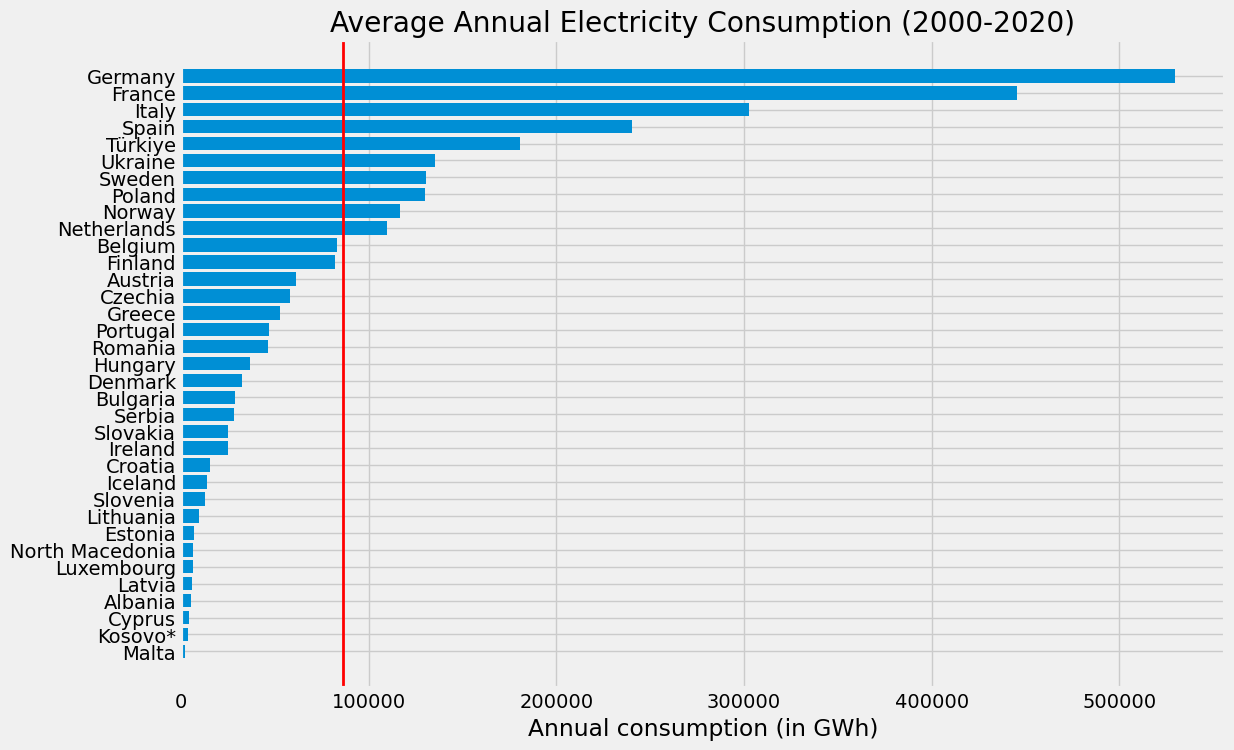

In [39]:
with plt.style.context('fivethirtyeight'):
    
    fig, ax = plt.subplots(figsize = (12, 8))

    # Create horizontal bar plot with country averages 
    ax.barh(
        mean_series.index,  # Use series index (country names) on the xaxis
        mean_series.values, # Use series values on the yaxis
    )

    # Add EU average as vertical line
    ax.axvline(x = mean_series.mean(), color = 'red', lw = 2, label ='Overall Average')

    # Formatting
    ax.set_title('Average Annual Electricity Consumption (2000-2020)')
    ax.set_xlabel('Annual consumption (in GWh)')
    # (use StrMethodFormatter from ticker to add thousand seperator on xaxis)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.legend()
    plt.show()